# 프로젝트: 한국어 QA 모델 만들기

- 아래 데이터셋은 bAbI 데이터셋을 필자가 한국어로 변환한 한국어 버전의 bAbI 데이터셋이다.
- 데이터셋에 대한 소개는 다음과 같다.
> 1. 형태는 아래와 같이영어 데이터셋과 동일한 형태를 가진다.
> ```c
1 은경이는 복도로 가버렸습니다.
2 필웅이는 화장실로 뛰어갔습니다.
3 은경이는 어디야?     복도  1
4 수종이는 화장실로 복귀했습니다.
5 은경이는 침실로 갔습니다.
6 필웅이는 어디야?     화장실 2
7 은경이는 복도로 이동했습니다.
8 경임이는 부엌으로 뛰어갔습니다.
9 경임이는 어디야?     부엌  8
10 경임이는 복도로 가버렸습니다.
11 은경이는 정원으로 이동했습니다.
12 경임이는 어디야?     복도  10
13 경임이는 화장실로 복귀했습니다.
14 경임이는 부엌으로 갔습니다.
15 경임이는 어디야?     부엌  14
> ```


- 이번 플로젝트에서는 위 한국어 버전의 데이터셋에 대해서 동장하는 QA 모델을 만들어보자.
> (주의!) 기존 케라스 공식 문서의 babi_rnn, babi_memn 구현은 파이썬 3.6을 기준으로 하고 있으며, 파이썬 3.7에서는 정상작동 하지 않을 수 있으니 실습 시에 참고바랍니다.


## Step 1. 데이터 다운로드

- 다운로드 받아서 압축 해제 후 사용한다.
- [e-28-korean.zip](https://drive.google.com/file/d/1GWwjTvSolEKGVuXxPsXJeVH8WCvaS-In/view?usp=sharing)

In [50]:
# 필요한 도구들 import
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import tarfile
from nltk import FreqDist
from functools import reduce
import os
import re

In [51]:
# 환경에 맞게 경로 적절히 수정
home_dir = os.getenv('HOME')+'/aiffel/babi_memory_net'
DATA_DIR = home_dir + '/e-28-korean'

# 훈련 데이터와 시험 데이터의 경로 지정
TRAIN_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_train_kor.txt")
TEST_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_test_kor.txt")

In [52]:
print(len(TRAIN_FILE))
print(len(TEST_FILE))

93
92


- 훈련 데이터에서 20개의 문장을 출력해보자.

In [53]:
i = 0
lines = open(TRAIN_FILE , "rb")
for line in lines:
    line = line.decode("utf-8").strip()
    # lno, text = line.split(" ", 1) # ID와 TEXT 분리
    i = i + 1
    print(line)
    if i == 20:
        break

1 필웅이는 화장실로 갔습니다.
2 은경이는 복도로 이동했습니다.
3 필웅이는 어디야? 	화장실	1
4 수종이는 복도로 복귀했습니다.
5 경임이는 정원으로 갔습니다.
6 수종이는 어디야? 	복도	4
7 은경이는 사무실로 갔습니다.
8 경임이는 화장실로 뛰어갔습니다.
9 수종이는 어디야? 	복도	4
10 필웅이는 복도로 갔습니다.
11 수종이는 사무실로 가버렸습니다.
12 수종이는 어디야? 	사무실	11
13 은경이는 정원으로 복귀했습니다.
14 은경이는 침실로 갔습니다.
15 경임이는 어디야? 	화장실	8
1 경임이는 사무실로 가버렸습니다.
2 경임이는 화장실로 이동했습니다.
3 경임이는 어디야? 	화장실	2
4 필웅이는 침실로 이동했습니다.
5 수종이는 복도로 갔습니다.


# Step 2. 토크나이저 변경하기 (매우 중요!!!)

- 영어권 언어는 띄어쓰기만해도 단어들이 잘 분리되지만, 한국어는 그렇지 않다고 앞에서 몇 차례 언급했다.
- 한국어 데이터를 사용하여 모델을 구현하는 것만큼 이번에는 형태소 분석기를 사용해서 단어 토큰화를 해보자.


- 그런데 형태소 분석기를 사용할 때, 이런 상황에 봉착한다면 어떻게 해야할까?
```
형태소 분석 입력 : '은경이는 사무실로 갔습니다.'
형태소 분석 결과 : ['은', '경이', '는', '사무실', '로', '갔습니다', '.']
```


- 사실 위 문장에서 '은경이'는 사람 이름이므로 제대로 된 결과를 얻기 위해서는 '은', '경이'와 같이 글자가 분리되는 것이 아니라 '은경이' 또는 최소한 '은경'이라는 단어 토큰을 얻어야만 한다.


- 이런 경우에는 형태소 분석기에 사용자 사전을 추가해줄 수 있다.
- '은경이'는 하나의 단어이기 때문에 분리하지말라고 형태소 분석기에 알려주는 것이다.


- 사용자 사전을 추가하는 방법은 형태소 분석기마다 다소 다른데, 생각보다 복잡한 경우도 많다.
- 이번 실습에서는 Customized Konlpy라는 사용자 사전 추가가 매우 쉬운 패키지를 사용하자.


## Customized Konlpy 설치 방법

- 설치 방법과 사용 방법에 대한 자세한 설명은 아래의 링크를 참고하라.
- [Customized Konlpy 사용하기](https://inspiringpeople.github.io/data%20analysis/ckonlpy/)


- 가령, 트위터라는 형태소 분석기를 사용한다고 했을 때, '은경이'라는 단어를 사용자 사전에 추가하고 나서 문장을 형태소 분석하려면 어떻게 해야 할까?

In [54]:
# 예시 코드
from ckonlpy.tag import Twitter
twitter = Twitter()
twitter.add_dictionary('은경이', 'Noun')
twitter.morphs('은경이는 사무실로 갔습니다.')

/home/aiffel-dj20/anaconda3/envs/aiffel/lib/python3.7/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


['은경이', '는', '사무실', '로', '갔습니다', '.']

- 모든 문장의 주어 부분을 자른 다음에 리스트에 넣고, set()을 사용하면 주어에 어떤 이름이 들어갔는지 볼 수 있지 않을까?

In [55]:
subjects = []
temp = []

lines = open(TRAIN_FILE , "rb")
for line in lines:
    line = line.decode("utf-8").strip()
    lno, text = line.split(" ", 1) # ID와 TEXT 분리
    temp = text[0:3]
    subjects.append(temp)    

In [56]:
set(subjects)

{'경임이', '수종이', '은경이', '필웅이'}

In [57]:
twitter.add_dictionary('경임이', 'Noun')
print(twitter.morphs('경임이는 사무실로 가버렸습니다.'))

twitter.add_dictionary('수종이', 'Noun')
print(twitter.morphs('수종이는 복도로 갔습니다.'))

twitter.add_dictionary('은경이', 'Noun')
print(twitter.morphs('은경이는 사무실로 갔습니다.'))

twitter.add_dictionary('필웅이', 'Noun')
print(twitter.morphs('필웅이는 어디야?'))

['경임이', '는', '사무실', '로', '가버렸습니다', '.']
['수종이', '는', '복도', '로', '갔습니다', '.']
['은경이', '는', '사무실', '로', '갔습니다', '.']
['필웅이', '는', '어디', '야', '?']


In [58]:
def read_data(dir):
    stories, questions, answers = [], [], [] # 각각 스토리, 질문, 답변을 저장할 예정
    story_temp = [] # 현재 시점의 스토리 임시 저장
    lines = open(dir, "rb")

    for line in lines:
        line = line.decode("utf-8") # b' 제거
        line = line.strip() # '\n' 제거
        idx, text = line.split(" ", 1) # 맨 앞에 있는 id number 분리
        # 여기까지는 모든 줄에 적용되는 전처리

        if int(idx) == 1:
            story_temp = []
        
        if "\t" in text: # 현재 읽는 줄이 질문 (tab) 답변 (tab)인 경우
            question, answer, _ = text.split("\t") # 질문과 답변을 각각 저장
            stories.append([x for x in story_temp if x]) # 지금까지의 누적 스토리를 스토리에 저장
            questions.append(question)
            answers.append(answer)

        else: # 현재 읽는 줄이 스토리인 경우
            story_temp.append(text) # 임시 저장

    lines.close()
    return stories, questions, answers

In [59]:
train_data = read_data(TRAIN_FILE)
test_data = read_data(TEST_FILE)

In [60]:
train_stories, train_questions, train_answers = read_data(TRAIN_FILE)
test_stories, test_questions, test_answers = read_data(TEST_FILE)

In [61]:
print("train 스토리 개수:", len(train_stories))
print("train 질문 개수:", len(train_questions))
print("train 답변 개수:", len(train_answers))
print("test 스토리 개수:", len(test_stories))
print("test 질문 개수:", len(test_questions))
print("test 답변 개수:", len(test_answers))

train 스토리 개수: 10000
train 질문 개수: 10000
train 답변 개수: 10000
test 스토리 개수: 1000
test 질문 개수: 1000
test 답변 개수: 1000


In [62]:
# 3879번째 스토리 출력
train_stories[3879]

['수종이는 화장실로 뛰어갔습니다.',
 '경임이는 사무실로 갔습니다.',
 '은경이는 부엌으로 이동했습니다.',
 '경임이는 화장실로 갔습니다.',
 '수종이는 복도로 갔습니다.',
 '필웅이는 부엌으로 가버렸습니다.',
 '수종이는 부엌으로 이동했습니다.',
 '수종이는 화장실로 가버렸습니다.',
 '필웅이는 사무실로 갔습니다.',
 '수종이는 사무실로 갔습니다.']

In [63]:
# 상위 5개 질문 출력
train_questions[:5]

['필웅이는 어디야? ', '수종이는 어디야? ', '수종이는 어디야? ', '수종이는 어디야? ', '경임이는 어디야? ']

In [64]:
# 상위 5개 답변 출력
train_answers[:5]

['화장실', '복도', '복도', '사무실', '화장실']

## Step 2. 형태소 분석 후 불용어 처리하기
- 형태소 분석기로 문자를 분석해보면 '는', '으로' 등 분석에 크게 도움이 되지 않을 것 같은 토큰들이 나올 것이다. 
- 처음에는 이 토큰들도 그대로 사용해서 모델을 구현해보고, 두 번째 구현에서는 이 토큰들을 전처리 과정에서 불용어 처리하여 제외해보자.

## 불용어 제거하지 않고 토큰화

In [65]:
def tokenize(sent):
    return [ x.strip() for x in re.sub(r"\s+|\b", '\f', sent).split('\f') if x.strip() ] # python 3.7의 경우 
    # return [ x.strip() for x in re.split('(\W+)?', sent) if x.strip()] # python 3.6의 경우

In [66]:
def preprocess_data(train_data, test_data):
    counter = FreqDist()
    
    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []
    
    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenize(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1
        
        for question in questions:
            question = tokenize(question)
            question_len.append(len(question))
            
            for word in question:
                counter[word] += 1
        
        for answer in answers:
            answer = tokenize(answer)
            
            for word in answer:
                counter[word] += 1

    # 단어장 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [67]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

In [68]:
print(word2idx)

{'.': 1, '경임이는': 2, '은경이는': 3, '수종이는': 4, '필웅이는': 5, '이동했습니다': 6, '가버렸습니다': 7, '뛰어갔습니다': 8, '복귀했습니다': 9, '갔습니다': 10, '화장실로': 11, '정원으로': 12, '복도로': 13, '어디야': 14, '?': 15, '부엌으로': 16, '사무실로': 17, '침실로': 18, '화장실': 19, '정원': 20, '사무실': 21, '침실': 22, '복도': 23, '부엌': 24}


In [69]:
vocab_size = len(word2idx) + 1

In [70]:
print('스토리의 최대 길이 :',story_max_len)
print('질문의 최대 길이 :',question_max_len)

스토리의 최대 길이 : 40
질문의 최대 길이 : 3


## Step 3. 한국어에서의 모델 정확도 확인해보기

- 앞서 만든 메모리 네트워크는 영어권 데이터에서는 보편적으로 약 96% 이상의 높은 성능을 보인다.
- 하이퍼파라미터를 잘 조정하면 이보다 더 높은 정확도가 나오기도 한다.
- 그렇다면 메모리 네트워크가 한국어에서도 영어만큼 잘 동작하는지 직접 확인해보자.


## 1. 불용어를 제거하지 않은 데이터를 사용한 모델

In [71]:
def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    
    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w] for w in tokenize(flatten(story))]
        xq = [word2idx[w] for w in tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

    # 스토리와 질문은 각각의 최대 길이로 패딩
    # 정답은 원-핫 인코딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

In [72]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

In [73]:
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)

(10000, 40) (10000, 3) (10000, 25) (1000, 40) (1000, 3) (1000, 25)


## 1번의 메모리 네트워크 구현

In [74]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation
import matplotlib.pyplot as plt

In [75]:
# 에포크 횟수
train_epochs = 120
# 배치 크기
batch_size = 32
# 임베딩 크기
embed_size = 50
# LSTM의 크기
lstm_size = 64
# 과적합 방지 기법인 드롭아웃 적용 비율
dropout_rate = 0.30

In [76]:
input_sequence = Input((story_max_len,))
question = Input((question_max_len,))
 
print('Stories :', input_sequence)
print('Question:', question)

Stories : KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")
Question: KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")


In [77]:
# 스토리를 위한 첫 번째 임베딩. 그림에서의 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embed_size) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원
 
# 스토리를 위한 두 번째 임베딩. 그림에서의 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩 벡터의 차원)

In [78]:
# 질문을 위한 임베딩. 그림에서의 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embed_size) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원

In [79]:
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m, '\n')
print('Input encoded c', input_encoded_c, '\n')
print('Question encoded', question_encoded, '\n')

Input encoded m KerasTensor(type_spec=TensorSpec(shape=(None, 40, 50), dtype=tf.float32, name=None), name='sequential_3/dropout_4/Identity:0', description="created by layer 'sequential_3'") 

Input encoded c KerasTensor(type_spec=TensorSpec(shape=(None, 40, 3), dtype=tf.float32, name=None), name='sequential_4/dropout_5/Identity:0', description="created by layer 'sequential_4'") 

Question encoded KerasTensor(type_spec=TensorSpec(shape=(None, 3, 50), dtype=tf.float32, name=None), name='sequential_5/dropout_6/Identity:0', description="created by layer 'sequential_5'") 



In [80]:
# 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
# 유사도는 내적을 사용한다.
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이

Match shape KerasTensor(type_spec=TensorSpec(shape=(None, 40, 3), dtype=tf.float32, name=None), name='activation_2/truediv:0', description="created by layer 'activation_2'")


In [81]:
# 매칭 유사도 행렬과 질문에 대한 임베딩을 더한다.
response = add([match, input_encoded_c])  # (samples, story_maxlen, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_maxlen)
print('Response shape', response)

Response shape KerasTensor(type_spec=TensorSpec(shape=(None, 3, 40), dtype=tf.float32, name=None), name='permute_1/transpose:0', description="created by layer 'permute_1'")


In [82]:
# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)
 
answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

Answer shape KerasTensor(type_spec=TensorSpec(shape=(None, 3, 90), dtype=tf.float32, name=None), name='concatenate_1/concat:0', description="created by layer 'concatenate_1'")


## 모델 학습

In [83]:
import os

# 모델 컴파일
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])
 
# 테스트 데이터를 검증 데이터로 사용하면서 모델 훈련 시작
history = model.fit([Xstrain, Xqtrain],
         Ytrain, batch_size, train_epochs,
         validation_data=([Xstest, Xqtest], Ytest))
 
# 훈련 후에는 모델 저장
model_path = os.getenv('HOME')+'/aiffel/babi_memory_net/model.h5'
model.save(model_path)

Epoch 1/120
313/313 [==============================] - 3s 5ms/step - loss: 2.0449 - acc: 0.1699 - val_loss: 1.7897 - val_acc: 0.1670
Epoch 2/120
313/313 [==============================] - 1s 4ms/step - loss: 1.7634 - acc: 0.2227 - val_loss: 1.6056 - val_acc: 0.3740
Epoch 3/120
313/313 [==============================] - 1s 3ms/step - loss: 1.5777 - acc: 0.3765 - val_loss: 1.4875 - val_acc: 0.4200
Epoch 4/120
313/313 [==============================] - 1s 3ms/step - loss: 1.5144 - acc: 0.3925 - val_loss: 1.4606 - val_acc: 0.4480
Epoch 5/120
313/313 [==============================] - 1s 3ms/step - loss: 1.4690 - acc: 0.4318 - val_loss: 1.3894 - val_acc: 0.4760
Epoch 6/120
313/313 [==============================] - 1s 3ms/step - loss: 1.4065 - acc: 0.4485 - val_loss: 1.3509 - val_acc: 0.4640
Epoch 7/120
313/313 [==============================] - 1s 3ms/step - loss: 1.3662 - acc: 0.4644 - val_loss: 1.3141 - val_acc: 0.4850
Epoch 8/120
313/313 [==============================] - 1s 3ms/step - 

313/313 [==============================] - 1s 3ms/step - loss: 0.0305 - acc: 0.9921 - val_loss: 0.0068 - val_acc: 0.9980
Epoch 63/120
313/313 [==============================] - 1s 3ms/step - loss: 0.0252 - acc: 0.9934 - val_loss: 0.0051 - val_acc: 0.9980
Epoch 64/120
313/313 [==============================] - 1s 3ms/step - loss: 0.0338 - acc: 0.9918 - val_loss: 0.0129 - val_acc: 0.9970
Epoch 65/120
313/313 [==============================] - 1s 3ms/step - loss: 0.0171 - acc: 0.9948 - val_loss: 0.0064 - val_acc: 0.9990
Epoch 66/120
313/313 [==============================] - 1s 3ms/step - loss: 0.0228 - acc: 0.9928 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 67/120
313/313 [==============================] - 1s 3ms/step - loss: 0.0193 - acc: 0.9935 - val_loss: 0.0084 - val_acc: 0.9970
Epoch 68/120
313/313 [==============================] - 1s 4ms/step - loss: 0.0171 - acc: 0.9954 - val_loss: 0.0053 - val_acc: 0.9990
Epoch 69/120
313/313 [==============================] - 1s 4ms/step - loss:

In [84]:
print("\n 테스트 정확도: %.4f" % (model.evaluate([Xstest, Xqtest], Ytest)[1]))

32/32 [==============================] - 0s 2ms/step - loss: 3.8931e-04 - acc: 1.0000

 테스트 정확도: 1.0000


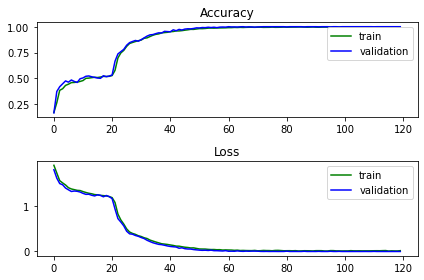

In [85]:
# plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

In [86]:
NUM_DISPLAY = 30

print("{:20}|{:7}|{}".format("질문", "실제값", "예측값"))
print(39 * "-")

for i in range(NUM_DISPLAY):
    question = " ".join([idx2word[x] for x in Xqtest[i].tolist()])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print("{:20}: {:8} {}".format(question, label, prediction))

질문                  |실제값    |예측값
---------------------------------------
은경이는 어디야 ?          : 복도       복도
필웅이는 어디야 ?          : 화장실      화장실
경임이는 어디야 ?          : 부엌       부엌
경임이는 어디야 ?          : 복도       복도
경임이는 어디야 ?          : 부엌       부엌
경임이는 어디야 ?          : 복도       복도
경임이는 어디야 ?          : 정원       정원
수종이는 어디야 ?          : 복도       복도
경임이는 어디야 ?          : 사무실      사무실
수종이는 어디야 ?          : 사무실      사무실
필웅이는 어디야 ?          : 부엌       부엌
필웅이는 어디야 ?          : 정원       정원
수종이는 어디야 ?          : 사무실      사무실
필웅이는 어디야 ?          : 침실       침실
필웅이는 어디야 ?          : 침실       침실
은경이는 어디야 ?          : 부엌       부엌
은경이는 어디야 ?          : 정원       정원
은경이는 어디야 ?          : 부엌       부엌
수종이는 어디야 ?          : 사무실      사무실
은경이는 어디야 ?          : 부엌       부엌
필웅이는 어디야 ?          : 복도       복도
은경이는 어디야 ?          : 사무실      사무실
은경이는 어디야 ?          : 사무실      사무실
경임이는 어디야 ?          : 복도       복도
수종이는 어디야 ?          : 침실       침실
경임이는 어디야 ?          : 침실       침실
필웅이는 어디야 ?          : 침실       침실
수종

## 2. 불용어를 제거한 데이터를 사용한 모델

## 불용어를 제거하고 토큰화

In [88]:
twitter = Twitter()

In [89]:
twitter.add_dictionary('은경이', 'Noun')
twitter.add_dictionary('경임이', 'Noun')
twitter.add_dictionary('수종이', 'Noun')

In [90]:
# stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] 
def tokenize_stop(sent):
    return twitter.morphs(sent) # 토큰화

In [91]:
def preprocess_data_stop(train_data, test_data):
    counter = FreqDist()
    
    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []
    stopwords = ['의','가','이','야','은','들','는','좀','잘','걍','과','도','를','으로','로','자','에','와','한','하다'] 
    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenize_stop(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            stories = [word for word in stories if not word in stopwords]
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1
        for question in questions:
            question = tokenize_stop(question)
            question = [word for word in question if not word in stopwords]
            question_len.append(len(question))
            for word in question:
                counter[word] += 1
        for answer in answers:
            answer = tokenize_stop(answer)
            answer = [word for word in answer if not word in stopwords]
            for word in answer:
                counter[word] += 1

    # 단어장 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [92]:
word2idx_stop, idx2word_stop, story_max_len_stop, question_max_len_stop = preprocess_data_stop(train_data, test_data)

In [93]:
print(word2idx_stop)

{'.': 1, '했습니다': 2, '경임이': 3, '은경이': 4, '수종이': 5, '필웅이': 6, '이동': 7, '가버렸습니다': 8, '뛰어갔습니다': 9, '복귀': 10, '화장실': 11, '정원': 12, '복도': 13, '갔습니다': 14, '사무실': 15, '부엌': 16, '침실': 17, '어디': 18, '?': 19}


In [94]:
vocab_size = len(word2idx_stop) + 1

In [95]:
print('스토리의 최대 길이 :',story_max_len_stop)
print('질문의 최대 길이 :',question_max_len_stop)

스토리의 최대 길이 : 50
질문의 최대 길이 : 3


In [96]:
def vectorize_stop(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)
     
    stopwords = ['의','가','이','야','은','들','는','좀','잘','걍','과','도','를','으로','로','자','에','와','한','하다']
    
    stories, questions, answers = data
    
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w] for w in tokenize_stop(flatten(story))]
        xs = [word for word in xs if not word in stopwords]
        
        xq = [word2idx[w] for w in tokenize_stop(question)]
        xq = [word for word in xq if not word in stopwords]
        
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

    # 스토리와 질문은 각각의 최대 길이로 패딩
    # 정답은 원-핫 인코딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

In [97]:
def vectorize_stop(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)
     
    stopwords = ['의','가','이','야','은','들','는','좀','잘','걍','과','도','를','으로','로','자','에','와','한','하다']
    
    stories, questions, answers = data
    
    for story, question, answer in zip(stories, questions, answers):
        xs = [w for w in tokenize_stop(flatten(story))]
        xs = [w for w in xs if not w in stopwords]
        xs = [word2idx[w] for w in xs]
        
        xq = [w for w in tokenize_stop(question)]
        xq = [w for w in xq if not w in stopwords]
        xq = [word2idx[w] for w in xq]
        
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

    # 스토리와 질문은 각각의 최대 길이로 패딩
    # 정답은 원-핫 인코딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

In [98]:
Xstrain_stop, Xqtrain_stop, Ytrain_stop = vectorize_stop(train_data, word2idx_stop, story_max_len_stop, question_max_len_stop)
Xstest_stop, Xqtest_stop, Ytest_stop = vectorize_stop(test_data, word2idx_stop, story_max_len_stop, question_max_len_stop)

In [99]:
print(Xstrain_stop.shape, Xqtrain_stop.shape, Ytrain_stop.shape, Xstest_stop.shape, Xqtest_stop.shape, Ytest_stop.shape)

(10000, 50) (10000, 3) (10000, 20) (1000, 50) (1000, 3) (1000, 20)


## 2번의 메모리 네트워크 구현

In [100]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation
import matplotlib.pyplot as plt

In [101]:
# 에포크 횟수
train_epochs = 120
# 배치 크기
batch_size = 32
# 임베딩 크기
embed_size = 50
# LSTM의 크기
lstm_size = 64
# 과적합 방지 기법인 드롭아웃 적용 비율
dropout_rate = 0.30

In [102]:
input_sequence = Input((story_max_len_stop,))
question = Input((question_max_len_stop,))
 
print('Stories :', input_sequence)
print('Question:', question)

Stories : KerasTensor(type_spec=TensorSpec(shape=(None, 50), dtype=tf.float32, name='input_5'), name='input_5', description="created by layer 'input_5'")
Question: KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name='input_6'), name='input_6', description="created by layer 'input_6'")


In [103]:
# 스토리를 위한 첫 번째 임베딩. 그림에서의 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embed_size) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원
 
# 스토리를 위한 두 번째 임베딩. 그림에서의 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩 벡터의 차원)

In [104]:
# 질문을 위한 임베딩. 그림에서의 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embed_size) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원

In [105]:
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m, '\n')
print('Input encoded c', input_encoded_c, '\n')
print('Question encoded', question_encoded, '\n')

Input encoded m KerasTensor(type_spec=TensorSpec(shape=(None, 50, 50), dtype=tf.float32, name=None), name='sequential_6/dropout_8/Identity:0', description="created by layer 'sequential_6'") 

Input encoded c KerasTensor(type_spec=TensorSpec(shape=(None, 50, 3), dtype=tf.float32, name=None), name='sequential_7/dropout_9/Identity:0', description="created by layer 'sequential_7'") 

Question encoded KerasTensor(type_spec=TensorSpec(shape=(None, 3, 50), dtype=tf.float32, name=None), name='sequential_8/dropout_10/Identity:0', description="created by layer 'sequential_8'") 



In [106]:
# 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
# 유사도는 내적을 사용한다.
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이

Match shape KerasTensor(type_spec=TensorSpec(shape=(None, 50, 3), dtype=tf.float32, name=None), name='activation_4/truediv:0', description="created by layer 'activation_4'")


In [107]:
# 매칭 유사도 행렬과 질문에 대한 임베딩을 더한다.
response = add([match, input_encoded_c])  # (samples, story_maxlen, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_maxlen)
print('Response shape', response)

Response shape KerasTensor(type_spec=TensorSpec(shape=(None, 3, 50), dtype=tf.float32, name=None), name='permute_2/transpose:0', description="created by layer 'permute_2'")


In [108]:
# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)
 
answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

Answer shape KerasTensor(type_spec=TensorSpec(shape=(None, 3, 100), dtype=tf.float32, name=None), name='concatenate_2/concat:0', description="created by layer 'concatenate_2'")


## 모델 학습

In [109]:
import os

# 모델 컴파일
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])
 
# 테스트 데이터를 검증 데이터로 사용하면서 모델 훈련 시작
history = model.fit([Xstrain_stop, Xqtrain_stop],
         Ytrain_stop, batch_size, train_epochs,
         validation_data=([Xstest_stop, Xqtest_stop], Ytest_stop))
 
# 훈련 후에는 모델 저장
model_path = os.getenv('HOME')+'/aiffel/babi_memory_net/model.h5'
model.save(model_path)

Epoch 1/120
313/313 [==============================] - 4s 5ms/step - loss: 2.0161 - acc: 0.1569 - val_loss: 1.7855 - val_acc: 0.1860
Epoch 2/120
313/313 [==============================] - 1s 3ms/step - loss: 1.7722 - acc: 0.2054 - val_loss: 1.6673 - val_acc: 0.2570
Epoch 3/120
313/313 [==============================] - 1s 3ms/step - loss: 1.6447 - acc: 0.2845 - val_loss: 1.5573 - val_acc: 0.3710
Epoch 4/120
313/313 [==============================] - 1s 3ms/step - loss: 1.5440 - acc: 0.3660 - val_loss: 1.5359 - val_acc: 0.3620
Epoch 5/120
313/313 [==============================] - 1s 3ms/step - loss: 1.5061 - acc: 0.3943 - val_loss: 1.5302 - val_acc: 0.3800
Epoch 6/120
313/313 [==============================] - 1s 3ms/step - loss: 1.4661 - acc: 0.4262 - val_loss: 1.3830 - val_acc: 0.4790
Epoch 7/120
313/313 [==============================] - 1s 4ms/step - loss: 1.4089 - acc: 0.4587 - val_loss: 1.3573 - val_acc: 0.4890
Epoch 8/120
313/313 [==============================] - 1s 4ms/step - 

313/313 [==============================] - 1s 3ms/step - loss: 0.2457 - acc: 0.9131 - val_loss: 0.2765 - val_acc: 0.9080
Epoch 63/120
313/313 [==============================] - 1s 3ms/step - loss: 0.2470 - acc: 0.9120 - val_loss: 0.2616 - val_acc: 0.9050
Epoch 64/120
313/313 [==============================] - 1s 3ms/step - loss: 0.2412 - acc: 0.9171 - val_loss: 0.2938 - val_acc: 0.8990
Epoch 65/120
313/313 [==============================] - 1s 3ms/step - loss: 0.2423 - acc: 0.9151 - val_loss: 0.2581 - val_acc: 0.9160
Epoch 66/120
313/313 [==============================] - 1s 3ms/step - loss: 0.2268 - acc: 0.9175 - val_loss: 0.2647 - val_acc: 0.9130
Epoch 67/120
313/313 [==============================] - 1s 3ms/step - loss: 0.2366 - acc: 0.9148 - val_loss: 0.2506 - val_acc: 0.9070
Epoch 68/120
313/313 [==============================] - 1s 3ms/step - loss: 0.2320 - acc: 0.9176 - val_loss: 0.2577 - val_acc: 0.9080
Epoch 69/120
313/313 [==============================] - 1s 3ms/step - loss:

In [110]:
print("\n 테스트 정확도: %.4f" % (model.evaluate([Xstest_stop, Xqtest_stop], Ytest_stop)[1]))

32/32 [==============================] - 0s 2ms/step - loss: 0.1575 - acc: 0.9520

 테스트 정확도: 0.9520


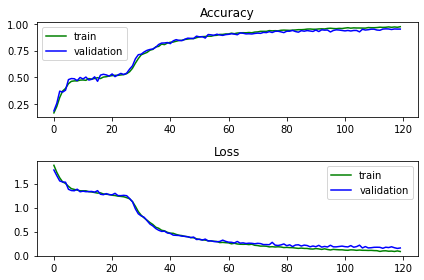

In [117]:
# plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(Ytest_stop, axis=1)

# get predictions
Ytest_ = model.predict([Xstest_stop, Xqtest_stop])
ytest_ = np.argmax(Ytest_, axis=1)

In [119]:
NUM_DISPLAY = 30

print("{:20}|{:7}|{}".format("질문", "실제값", "예측값"))
print(39 * "-")

for i in range(NUM_DISPLAY):
    question = " ".join([idx2word_stop[x] for x in Xqtest_stop[i].tolist()])
    label = idx2word_stop[ytest_[i]]
    prediction = idx2word_stop[ytest_[i]]
    print("{:20}: {:8} {}".format(question, label, prediction))

질문                  |실제값    |예측값
---------------------------------------
은경이 어디 ?            : 복도       복도
필웅이 어디 ?            : 화장실      화장실
경임이 어디 ?            : 부엌       부엌
경임이 어디 ?            : 복도       복도
경임이 어디 ?            : 부엌       부엌
경임이 어디 ?            : 복도       복도
경임이 어디 ?            : 정원       정원
수종이 어디 ?            : 복도       복도
경임이 어디 ?            : 사무실      사무실
수종이 어디 ?            : 사무실      사무실
필웅이 어디 ?            : 부엌       부엌
필웅이 어디 ?            : 정원       정원
수종이 어디 ?            : 사무실      사무실
필웅이 어디 ?            : 침실       침실
필웅이 어디 ?            : 침실       침실
은경이 어디 ?            : 부엌       부엌
은경이 어디 ?            : 정원       정원
은경이 어디 ?            : 부엌       부엌
수종이 어디 ?            : 사무실      사무실
은경이 어디 ?            : 침실       침실
필웅이 어디 ?            : 복도       복도
은경이 어디 ?            : 사무실      사무실
은경이 어디 ?            : 사무실      사무실
경임이 어디 ?            : 복도       복도
수종이 어디 ?            : 침실       침실
경임이 어디 ?            : 침실       침실
필웅이 어디 ?            : 침실       침실
수종

*****
# 루브릭 평가

|평가문항|상세기준|
|:----|:----|
|1. 한국어의 특성에 알맞게 전처리가 진행되었다.|한국어 특성에 따른 토큰화, 임베딩을 거쳐 데이터셋이 적절히 구성되었다.|
|2. 메모리 네트워크가 정상적으로 구현되어 학습이 안정적으로 진행되었다.|validation loss가 안정적으로 수렴하는 것을 확인하고 이를 시각화하였다.|
|3. 메모리 네트워크를 통해 한국어 bAbI 태스크의 높은 정확도를 달성하였다.|추론 태스크의 테스트 정확도가 90% 이상 달성하였다.|

1. mecab은 사용하지 않았다. 왜냐하면 이번 문장들은 다소 쉬운 문장구조를 가지고 있었기 때문이다. 결과도 좋게 나온 것 같다. 불용어는 제거하지 않은 버전과 제거한 버전을 가지고 모델을 돌려보았다. 불용어를 제거한 쪽이 조금 성능이 덜 나왔다.


2. 정확도가 안정적으로 수렴하는 것을 표로 도출하여 확인하였다.


3. 불용어 제거하지 않은 버전과 제거한 버전 모두 정확도가 90%이상 나옴을 확인했다.

# 회고

오랜만에 끝까지 한 노드였다. 중간에 모델 학습 부분에서 incompatible Error가 떠서 포기할까 했는데 셀의 위치를 변경시키니 돌아갔다. 분명 내가 잘못 전처리를 한 것도 아니고 규격을 다 맞췄는데, 에러가 나서 좀 당황했다. 그래도 됐으니 다행이다.